### Import modules

In [1]:
# Standard imports
import pandas as pd
import sys
import os
import seaborn as sns
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 

# Local imports
sys.path.insert(1, os.path.join(sys.path[0], ".."))
from tune_octupole import analysis_functions

# Apply better style
analysis_functions.apply_heatmap_style()

### Get simulation

In [2]:
# Define study
STUDY_NAME = "tune_scan_2024_angle"
COLLIDER = "collider_00"
PARQUET_PATH = f"../../scans/{STUDY_NAME}/da_complete.parquet"
CONF_MAD_PATH = f"../../scans/{STUDY_NAME}/{COLLIDER}/config.yaml"
CONF_COLLIDER_PATH = f"../../scans/{STUDY_NAME}/{COLLIDER}/xtrack_0005/config.yaml"

# Load dataframe
df_init = pd.read_parquet(PARQUET_PATH)

# Round all numbers to 3 decimals
df_init = df_init.round(3)

In [3]:
df_init

at_turn  state  \
beam  qx     qy     particle_id                     
lhcb1 62.305 60.305 0            1000000.0    1.0   
                    1            1000000.0    1.0   
                    2            1000000.0    1.0   
                    3            1000000.0    1.0   
                    4            1000000.0    1.0   
...                                    ...    ...   
      62.329 60.329 1275             271.0   -1.0   
                    1276             298.0   -1.0   
                    1277             320.0   -1.0   
                    1278            2013.0   -1.0   
                    1279             404.0   -1.0   

                                 normalized amplitude in xy-plane  \
beam  qx     qy     particle_id                                     
lhcb1 62.305 60.305 0                                       2.000   
                    1                                       2.031   
                    2                                       2.062   
                    3                                       2.094   
                    4                                       2.125   
...                                                           ...   
      62.329 60.329 1275                                    9.844   
                    1276                                    9.875   
                    1277                                    9.906   
                    1278                                    9.938   
                    1279                                    9.969   

                                 angle in xy-plane [deg]      qx      qy  \
beam  qx     qy     particle_id                                            
lhcb1 62.305 60.305 0                               15.0  62.305  60.305   
                    1                               15.0  62.305  60.305   
                    2                               15.0  62.305  60.305   
                    3                               15.0  62.305  60.305   
                    4                               15.0  62.305  60.305   
...                                                  ...     ...     ...   
      62.329 60.329 1275                            75.0  62.329  60.329   
                    1276                            75.0  62.329  60.329   
                    1277                            75.0  62.329  60.329   
                    1278                            75.0  62.329  60.329   
                    1279                            75.0  62.329  60.329   

                                 i_bunch_b1  i_bunch_b2  crossing_angle  
beam  qx     qy     particle_id                                          
lhcb1 62.305 60.305 0                 411.0       410.0           155.0  
                    1                 411.0       410.0           155.0  
                    2                 411.0       410.0           155.0  
                    3                 411.0       410.0           155.0  
                    4                 411.0       410.0           155.0  
...                                     ...         ...             ...  
      62.329 60.329 1275              411.0       410.0           155.0  
                    1276              411.0       410.0           155.0  
                    1277              411.0       410.0           155.0  
                    1278              411.0       410.0           155.0  
                    1279              411.0       410.0           155.0  

[409600 rows x 9 columns]

In [4]:
df_usual_plot = df_init[df_init["state"] == -1].reset_index(drop=True)


# Group by working point (Update this with the knobs you want to group by !)
group_by_parameters = ["qx", "qy"]

l_parameters_to_keep = [
    "normalized amplitude in xy-plane",
    "qx",
    "qy",
]

# Min is computed in the groupby function, but values should be identical
df_usual_plot = pd.DataFrame(
    [
        df_usual_plot.groupby(group_by_parameters)[parameter].min()
        for parameter in l_parameters_to_keep
    ]
).transpose()

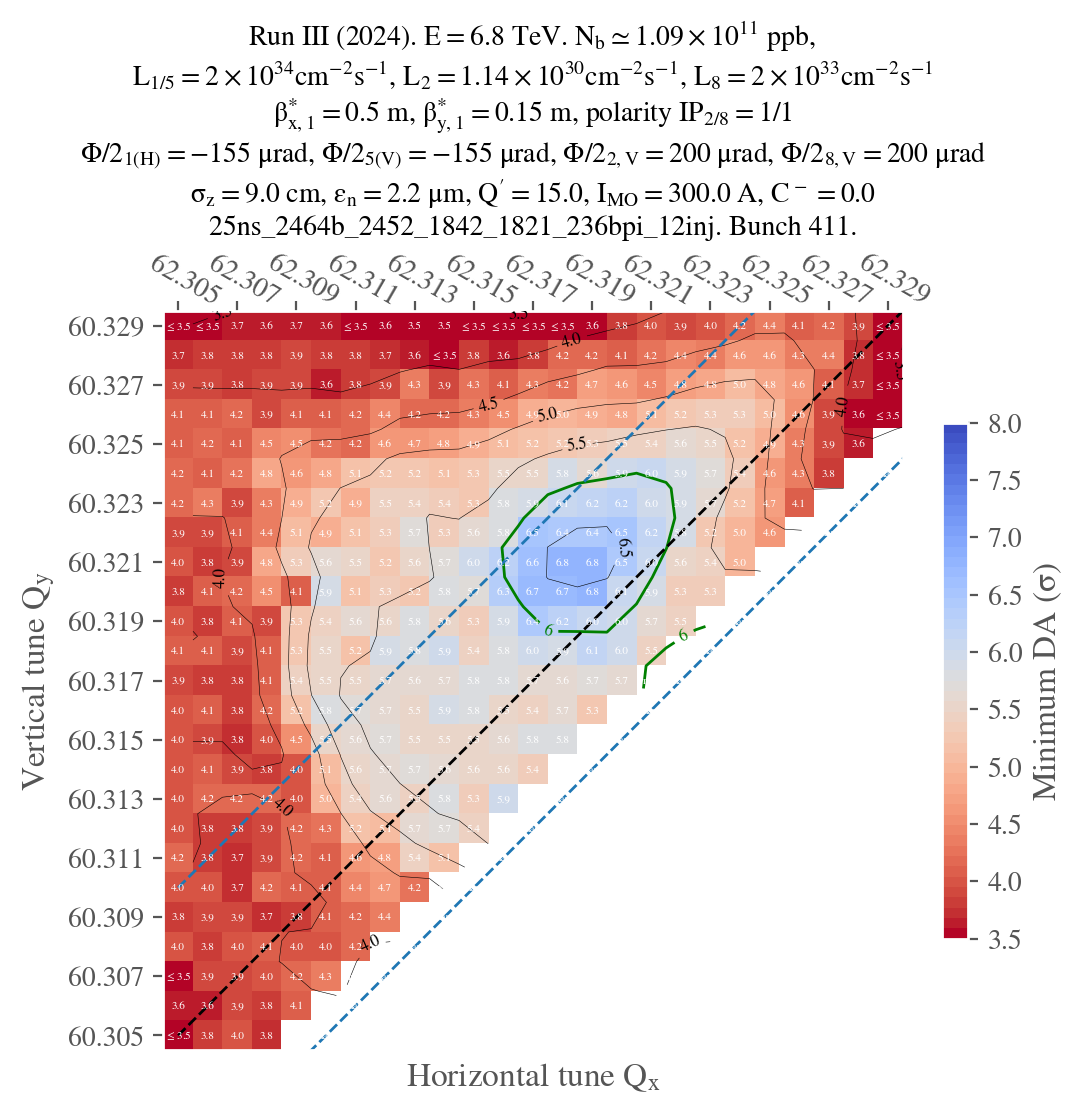

In [5]:
# Reshape for plotting
df_to_plot = df_usual_plot.pivot(
    index="qy", columns="qx", values="normalized amplitude in xy-plane"
)
df_to_plot
# Load configuration files
conf_mad = analysis_functions.load_config(CONF_MAD_PATH)["config_mad"]
conf_collider = analysis_functions.load_config(CONF_COLLIDER_PATH)["config_collider"]
analysis_functions.plot_heatmap(
    df_to_plot,
    STUDY_NAME + "_" + COLLIDER,
    link=None,
    plot_contours=True,
    conf_mad=conf_mad,
    conf_collider=conf_collider,
    type_crossing="flathv",
    betx=0.5,
    bety=0.15,
    Nb=True,
    extended_diagonal=True,
    vmin=3.5,
    vmax=8,
)

#### Apply better style for next plots

In [6]:
import matplotlib
# Apply better style
sns.set_theme(style="whitegrid")
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
#sns.set(font='Adobe Devanagari')
sns.set_context("paper", font_scale=1, rc={"lines.linewidth": 0.5, "grid.linewidth": 0.3})


matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
# Not italized latex
matplotlib.rcParams['mathtext.default'] = 'regular'
matplotlib.rcParams["font.weight"] = "light"

#%config InlineBackend.figure_format='svg'
# Retina display
%config InlineBackend.figure_format='retina'

In [7]:
l_df_best = []
for qx in np.linspace(62.305, 62.329, 25, endpoint=True):
    for qy in np.linspace(60.305, 60.329, 25, endpoint=True):
        df_best = df_init[(df_init["qx"] == qx) & (df_init["qy"] == qy)]
        if len(df_best) > 1120:
            print(qx, qy, len(df_best))


62.309 60.328 1280
62.32 60.326 1280
62.323 60.321 1280
62.324 60.325 1280


### Plot survival map

In [8]:
WP = (62.323, 60.321)

df_best = df_init[(df_init["qx"] == WP[0]) & (df_init["qy"] == WP[1])]



In [9]:
df_best

at_turn  state  \
beam  qx     qy     particle_id                     
lhcb1 62.323 60.321 0            1000000.0    1.0   
                    1            1000000.0    1.0   
                    2            1000000.0    1.0   
                    3            1000000.0    1.0   
                    4            1000000.0    1.0   
...                                    ...    ...   
                    1275           18660.0   -1.0   
                    1276           26507.0   -1.0   
                    1277           60470.0   -1.0   
                    1278            7909.0   -1.0   
                    1279           74232.0   -1.0   

                                 normalized amplitude in xy-plane  \
beam  qx     qy     particle_id                                     
lhcb1 62.323 60.321 0                                       2.000   
                    1                                       2.031   
                    2                                       2.062   
                    3                                       2.094   
                    4                                       2.125   
...                                                           ...   
                    1275                                    9.844   
                    1276                                    9.875   
                    1277                                    9.906   
                    1278                                    9.938   
                    1279                                    9.969   

                                 angle in xy-plane [deg]      qx      qy  \
beam  qx     qy     particle_id                                            
lhcb1 62.323 60.321 0                               15.0  62.323  60.321   
                    1                               15.0  62.323  60.321   
                    2                               15.0  62.323  60.321   
                    3                               15.0  62.323  60.321   
                    4                               15.0  62.323  60.321   
...                                                  ...     ...     ...   
                    1275                            75.0  62.323  60.321   
                    1276                            75.0  62.323  60.321   
                    1277                            75.0  62.323  60.321   
                    1278                            75.0  62.323  60.321   
                    1279                            75.0  62.323  60.321   

                                 i_bunch_b1  i_bunch_b2  crossing_angle  
beam  qx     qy     particle_id                                          
lhcb1 62.323 60.321 0                 411.0       410.0           155.0  
                    1                 411.0       410.0           155.0  
                    2                 411.0       410.0           155.0  
                    3                 411.0       410.0           155.0  
                    4                 411.0       410.0           155.0  
...                                     ...         ...             ...  
                    1275              411.0       410.0           155.0  
                    1276              411.0       410.0           155.0  
                    1277              411.0       410.0           155.0  
                    1278              411.0       410.0           155.0  
                    1279              411.0       410.0           155.0  

[1280 rows x 9 columns]

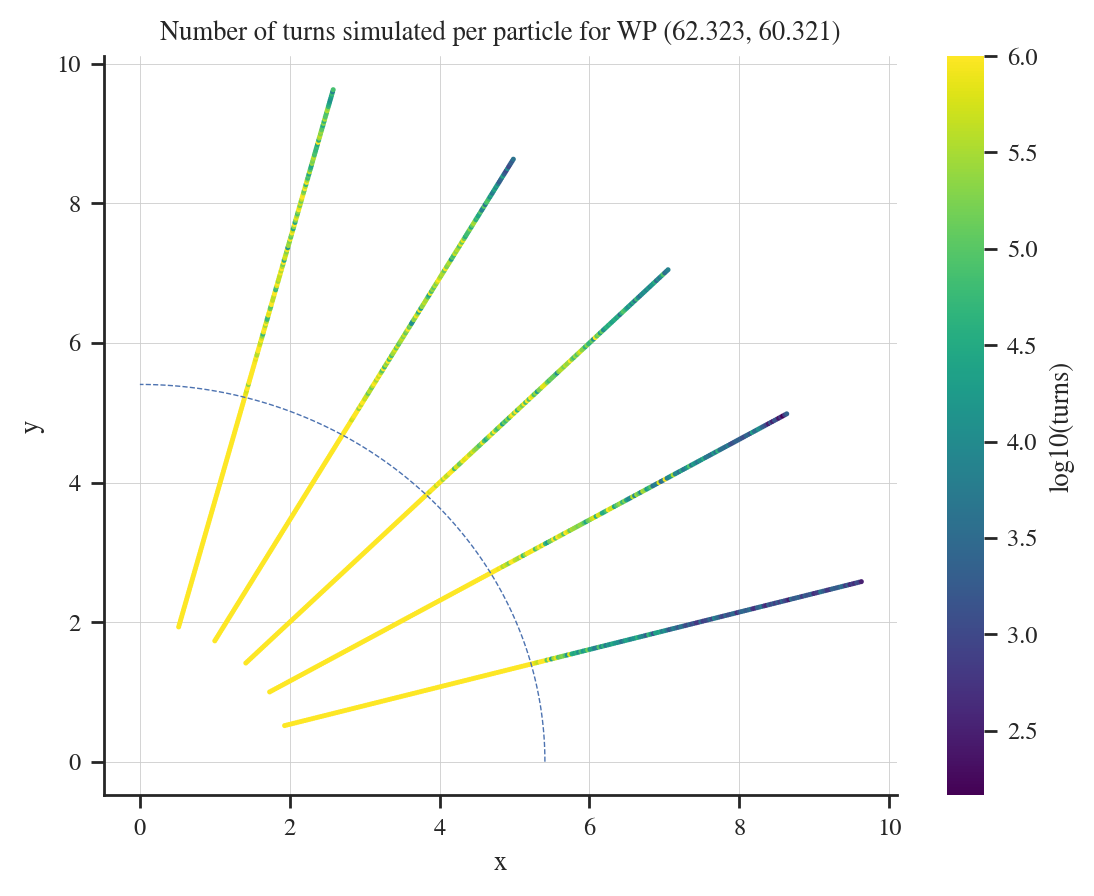

In [10]:
R = df_best["normalized amplitude in xy-plane"]
theta = df_best["angle in xy-plane [deg]"]/360 * 2 * np.pi
turns = np.log10(df_best["at_turn"])
plt.scatter( R * np.cos(theta), R * np.sin(theta), c=turns,  s = 1, cmap="viridis")
# Get minimum amplitude and plot circular arc
R_min = df_best[df_best['state'] == -1]["normalized amplitude in xy-plane"].min()
theta_min = np.linspace(0, np.pi/2, 100)
plt.plot( R_min * np.cos(theta_min), R_min * np.sin(theta_min), "--")
plt.xlabel("x")
plt.ylabel("y")
cb = plt.colorbar(label="log10(turns)")
cb.outline.set_visible(False)
plt.title("Number of turns simulated per particle for WP (62.323, 60.321)")
plt.grid()
plt.show()

### Strategy for simulation speedup

Could one periodically check a job to interrupt the simulations of all particles whose amplitude is above one that has already been lost?

Things to consider:
1) It seems quite hard to have jobs communicate with each other
2) It seems relatively simple to stop a simulation, check its state, and restart it with some particles removed
3) Granted that we keep simulating all particles of a given angle (all amplitudes), is it worth it?

Let's adress point 3, as a homogeneous distribution of particles makes point 1 less relevant. Let's assume we periodically check the simulation every 100 000 turns.


In [11]:
def filter_simulation_state(df, n_turns):
    # Make a copy and set the number of turns simulated to n_turns
    df_min = df.copy()
    df_min["at_turn"] = df_min["at_turn"].apply(lambda x: np.min((x, n_turns)))
    return df_min


def plot_simulation_state(df, n_turns, WP=(62.323, 60.321), DA=R_min):
    df_min = filter_simulation_state(df, n_turns)

    R = df_min["normalized amplitude in xy-plane"]
    theta = df_min["angle in xy-plane [deg]"] / 360 * 2 * np.pi
    turns = np.log10(df_min["at_turn"])
    plt.scatter(R * np.cos(theta), R * np.sin(theta), c=turns, s = 1, cmap="viridis")
    # Get minimum amplitude and plot circular arc
    theta_min = np.linspace(0, np.pi / 2, 100)
    plt.plot(DA * np.cos(theta_min), DA * np.sin(theta_min), "-")

    l_current_DA = []
    l_angle = [15, 30, 45, 60, 75]
    for angle in l_angle:
        R_min_current = df_min[
            (df_min["state"] == -1)
            & (df_min["at_turn"] < n_turns)
            & (df_min["angle in xy-plane [deg]"] == angle)
        ]["normalized amplitude in xy-plane"].min()
        l_current_DA.append(R_min_current)
        theta_min = np.linspace(0, np.pi / 2, 100)
        plt.plot(
            R_min_current * np.cos(theta_min),
            R_min_current * np.sin(theta_min),
            color="grey",
            linestyle="--",
        )

    plt.clim(2, 6)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    cb = plt.colorbar(label="log10(turns)")
    cb.outline.set_visible(False)
    plt.title(f"Turns simulated per particle for WP {WP}. ({n_turns:.0e} turns simulated)")
    plt.grid()
    plt.show()

    return l_current_DA, l_angle

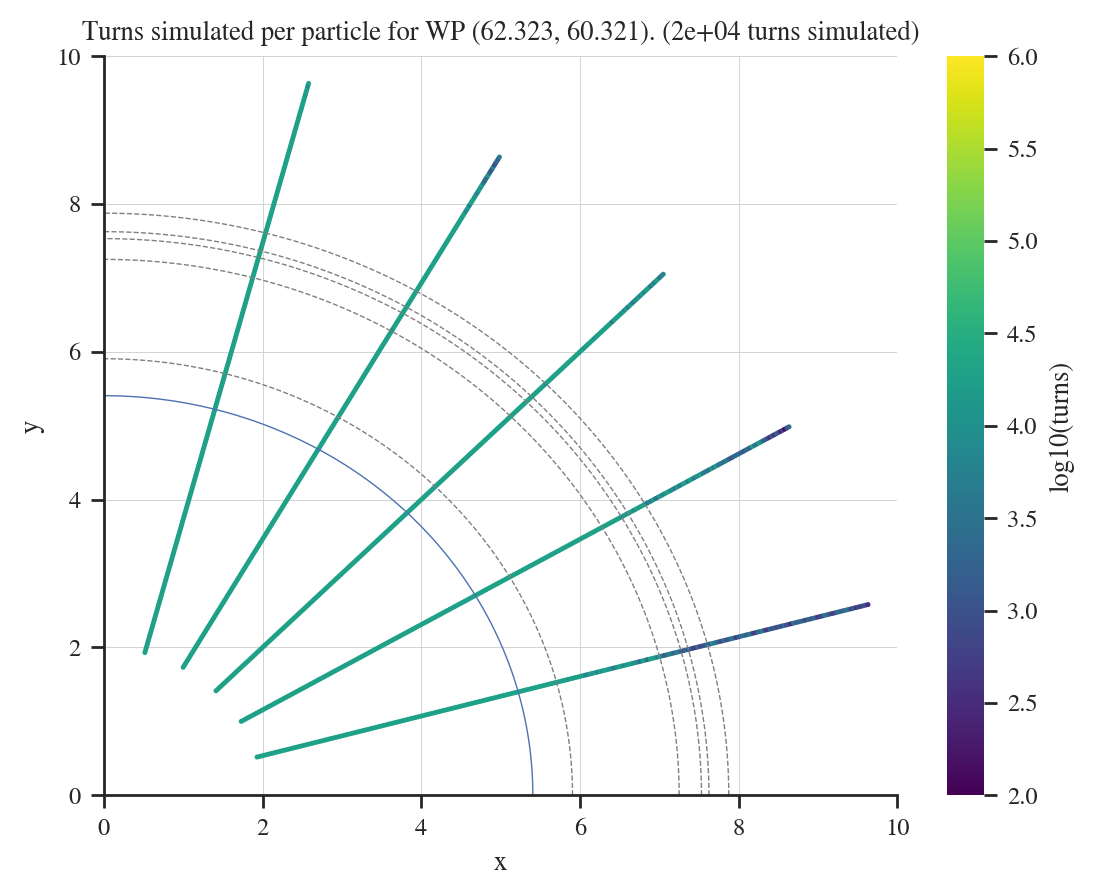

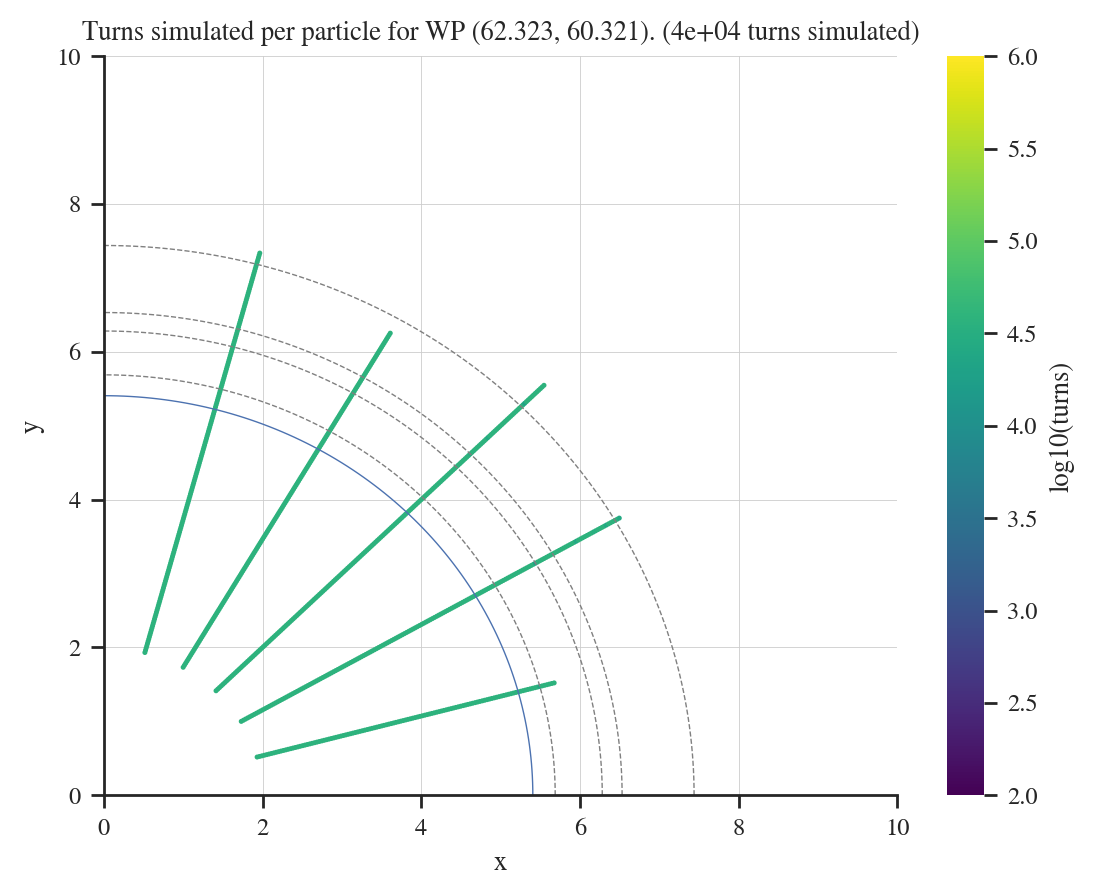

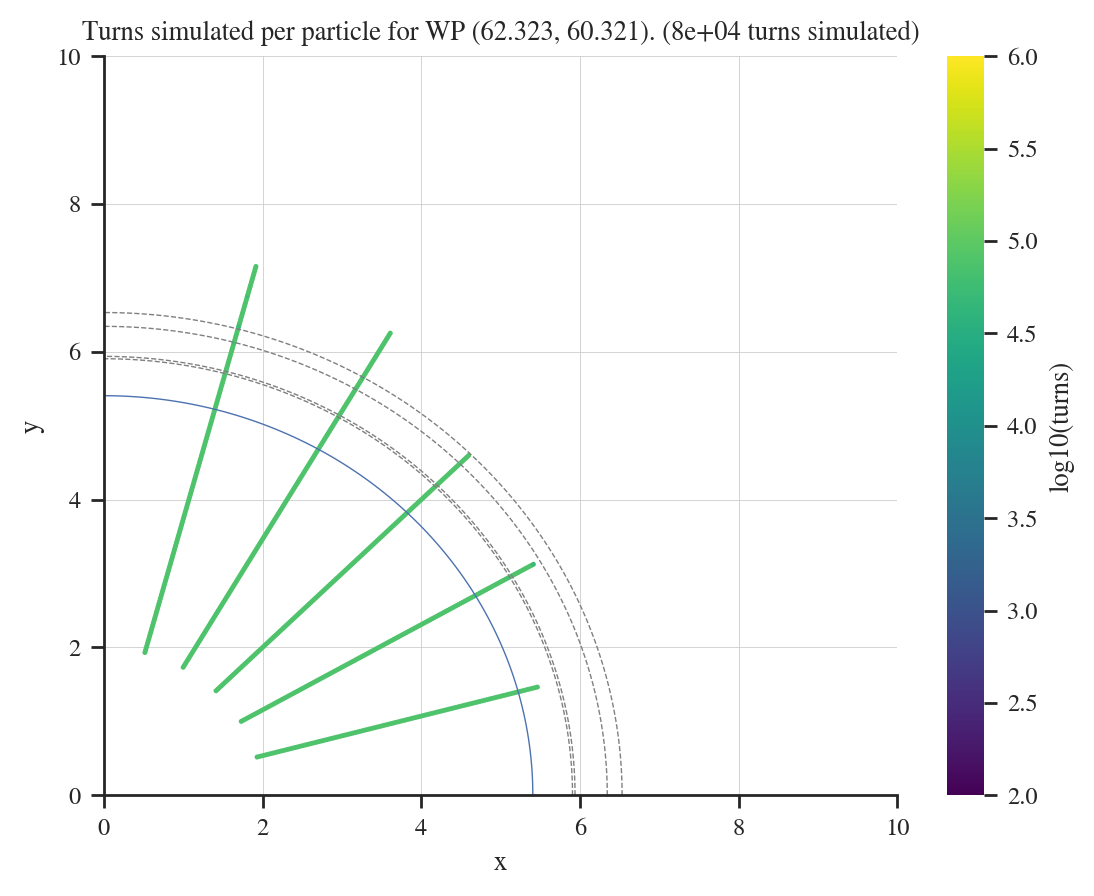

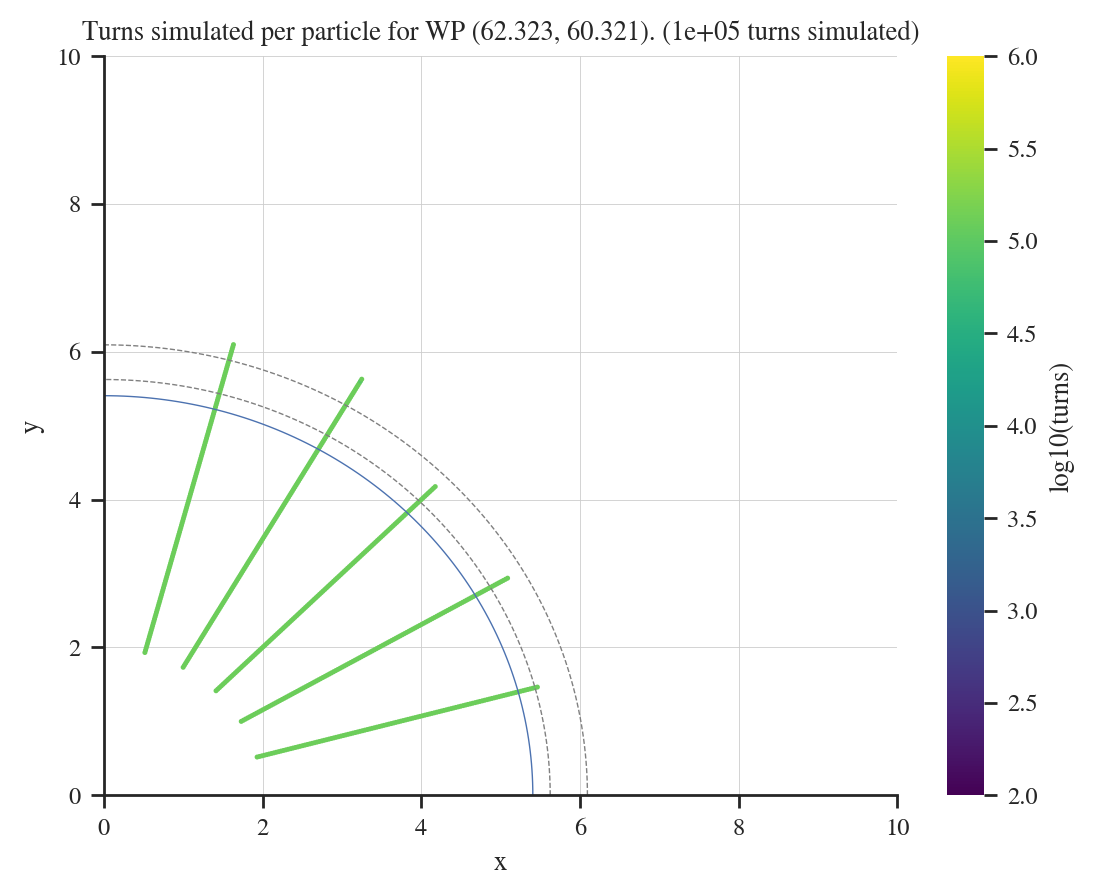

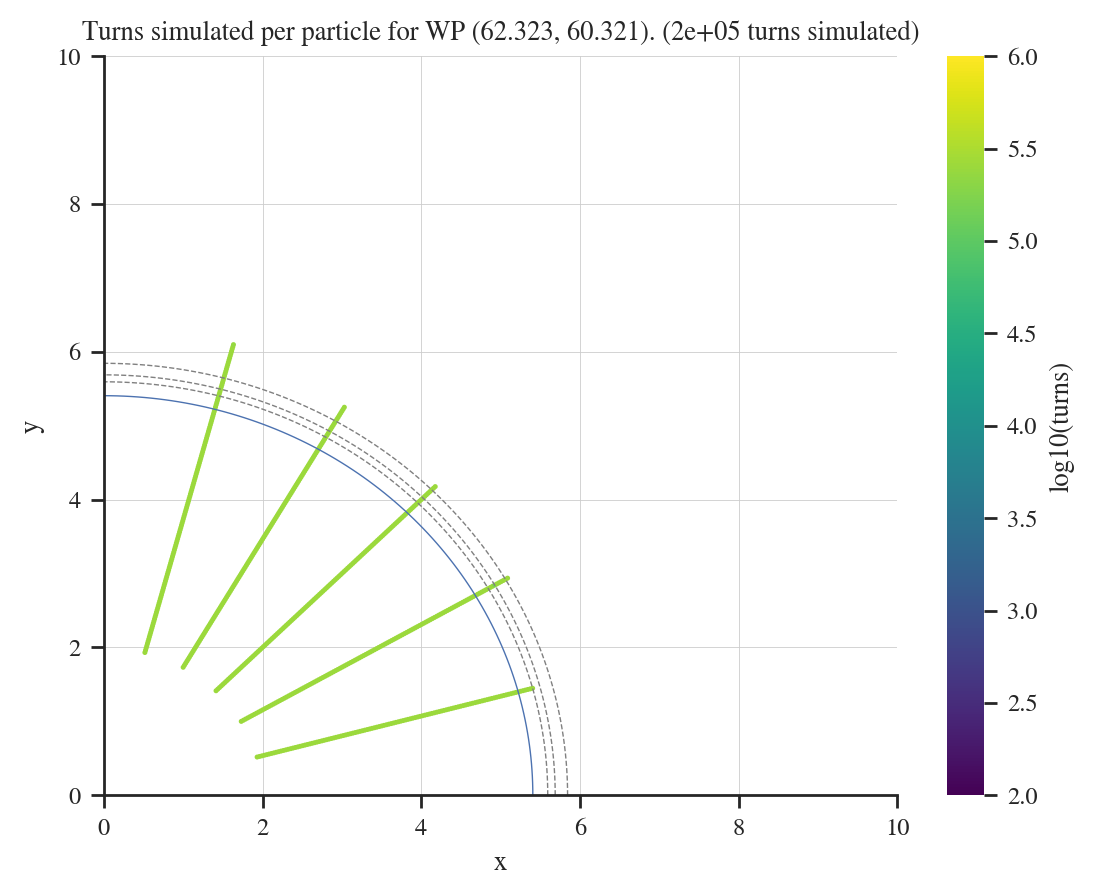

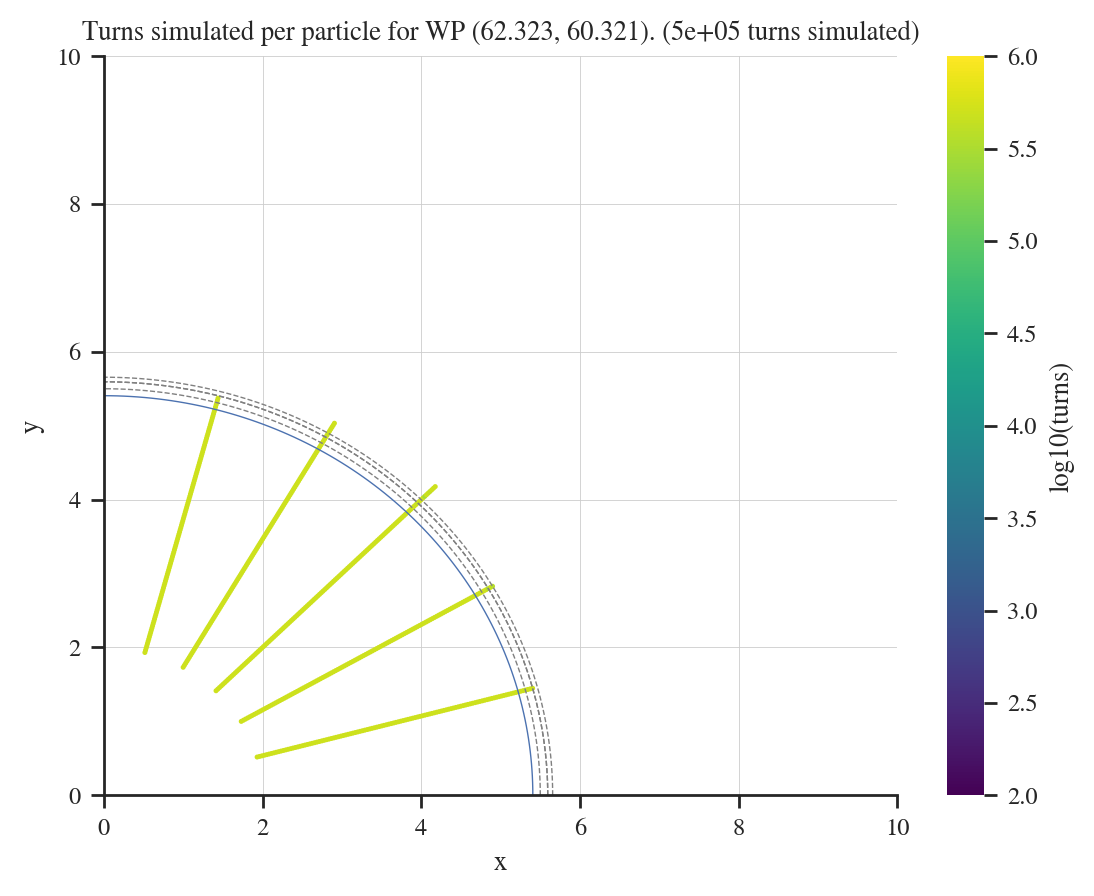

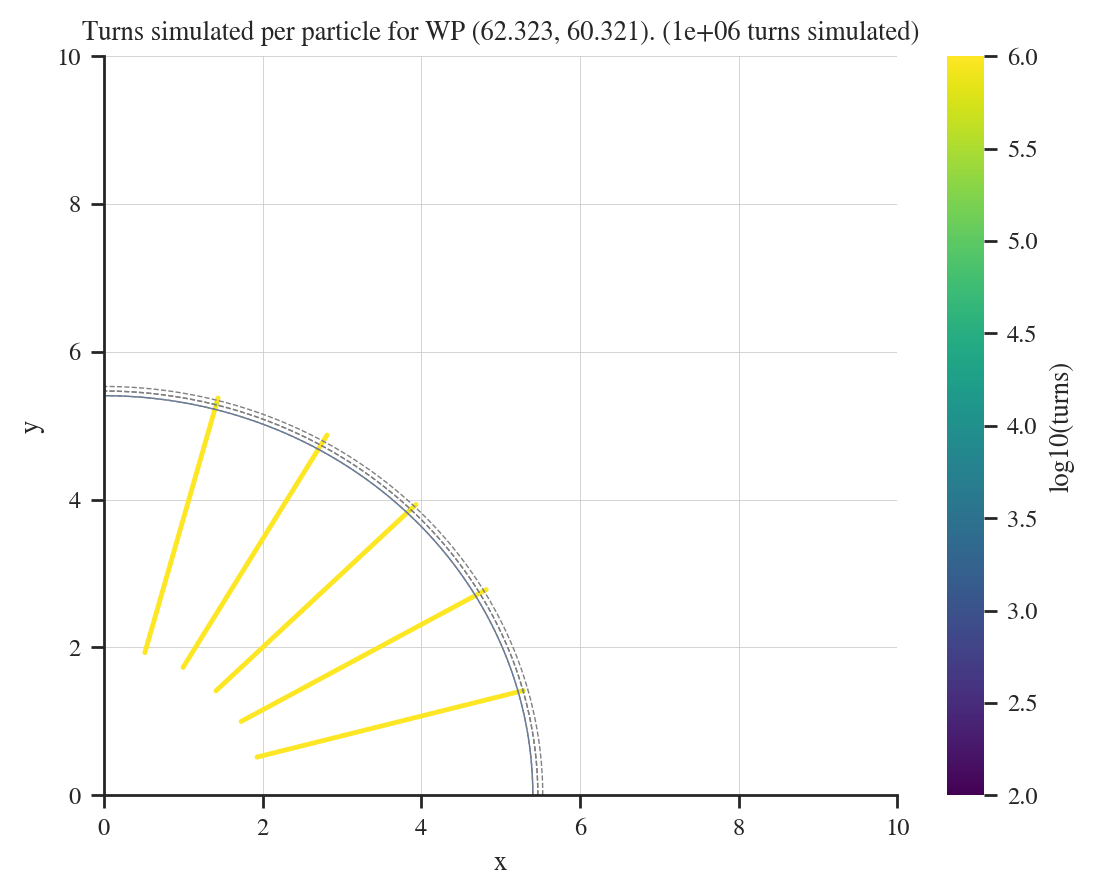

In [12]:
df = df_best.copy()
l_tot_turns_spared = []
l_checkpoints = [18750, 37500, 75000,125000,250000,500000, 1000000]
for n_turns in l_checkpoints:
    # Get current simulation state and plot
    l_current_DA, l_angle = plot_simulation_state(df, n_turns = n_turns, WP = WP)
    # Remove particles that are above particles already lost for each angle
    sub_tot_turns_spared = 0
    for current_DA, angle in zip(l_current_DA, l_angle):
        if not np.isnan(current_DA):
            df_angle = df[df["angle in xy-plane [deg]"] == angle]
            
            # Check how many turns will be spared (not simulated)
            df_removed_particles = df_angle[df_angle["normalized amplitude in xy-plane"] >= current_DA]
            tot_turns_removed = df_removed_particles['at_turn'].sum()
            tot_turns_simulated = df_removed_particles['at_turn'].apply(lambda x: np.min((x, n_turns))).sum()
            sub_tot_turns_spared += tot_turns_removed - tot_turns_simulated
            
            df_angle_filtered = df_angle[df_angle["normalized amplitude in xy-plane"] < current_DA]
            # Merge back into df
            df = pd.concat([df_angle_filtered, df[df["angle in xy-plane [deg]"] != angle]])
            
    l_tot_turns_spared.append(sub_tot_turns_spared)

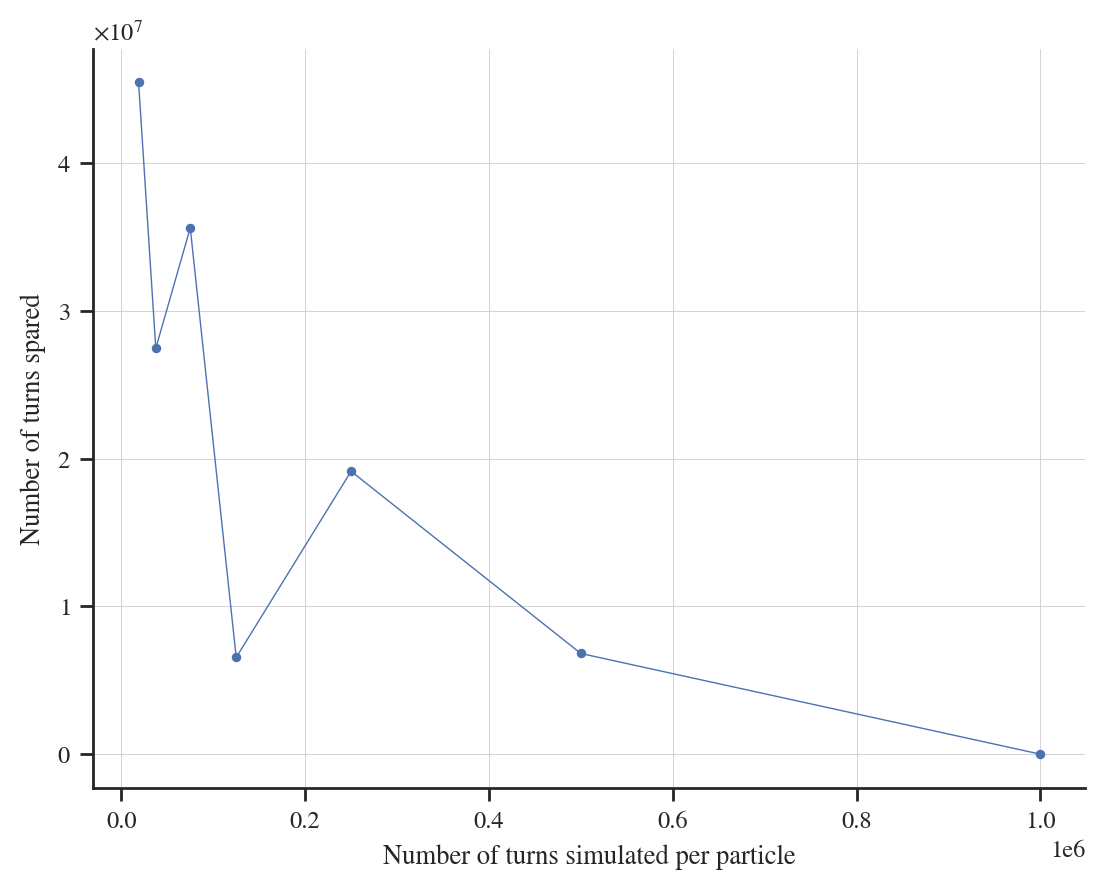

In [13]:
# Comparison of turns simulated with and without periodic checking
fig, ax = plt.subplots()
plt.plot(l_checkpoints, l_tot_turns_spared, ".-")
ax.yaxis.set_major_formatter(formatter) 
#ax.xaxis.set_major_formatter(formatter) 
plt.xlabel('Number of turns simulated per particle')
plt.ylabel('Number of turns spared')
plt.grid()
plt.show()

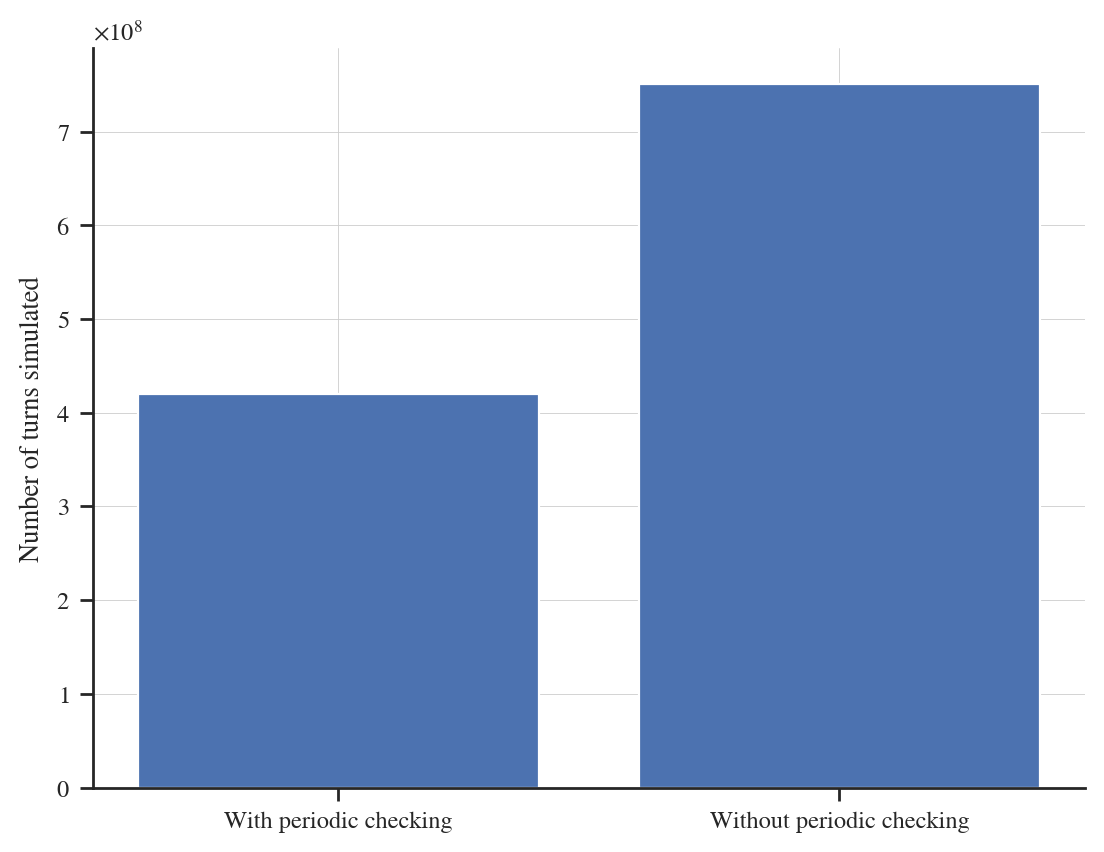

55.89348295204887


In [14]:
# Total number of turns simulated with this strategy vs without
tot_turns = df_best['at_turn'].sum()
tot_turns_with_checkpoints = df['at_turn'].sum() - np.sum(l_tot_turns_spared)
fig, ax = plt.subplots()
plt.bar(["With periodic checking", "Without periodic checking"], [tot_turns_with_checkpoints, tot_turns])
plt.ylabel("Number of turns simulated")
ax.yaxis.set_major_formatter(formatter) 
plt.grid()
plt.show()

print(tot_turns_with_checkpoints/tot_turns*100)

Assuming we can stop a job at pre-specified checkoints, and remove the particles above the current DA, this would mean a gain of about 40% in simulation time (excluding the first 5% to configure the collider), for a WP that has a DA of about 5.5. Bigger gains are expected for lower DA (and conversely).

### Additional strategy for simulation speedup

For now, we simulate all particles, at all angles and amplitude, for the maximum number of turns they survive. Yet, in an ideal world, we would first simulate the particles at very low amplitude, check if they all survive, then progressively raise the amplitude until one particle gets lost : the corresponding amplitude is the DA.

This is not doable as simulating one particle for 1M turns already takes a very long time, and therefore we need to parallelize as much as possible. Yet, we could still be a bit bolder and makes the simulation in several steps. 

First simulate particles of medium to large amplitude (e.g. amplitude between 4.5 and 6.5):
- If they all survive, then most likely we don't need to simulate particles with lower amplitude, and can go from e.g 6.5 to 10. 
- Conversely, if none of them survive, we know the DA is lower and we can simulate particles with amplitude between 2 and 4.5.
- If some survive and some don't, then we can either simulate entirely the particles with amplitude between 2 and 4.5 (as in the previous case), but we can be even bolder and assume that if e.g. all particles between 4.5 and 5 have survived, then the DA is most likely already found from the particles lost in the current interval. Therefore, we don't need anymore simulations.

Let's test the gain from this strategy, assuming that we don't apply the previous strategy.
 

Plot survival of all particles for all angles

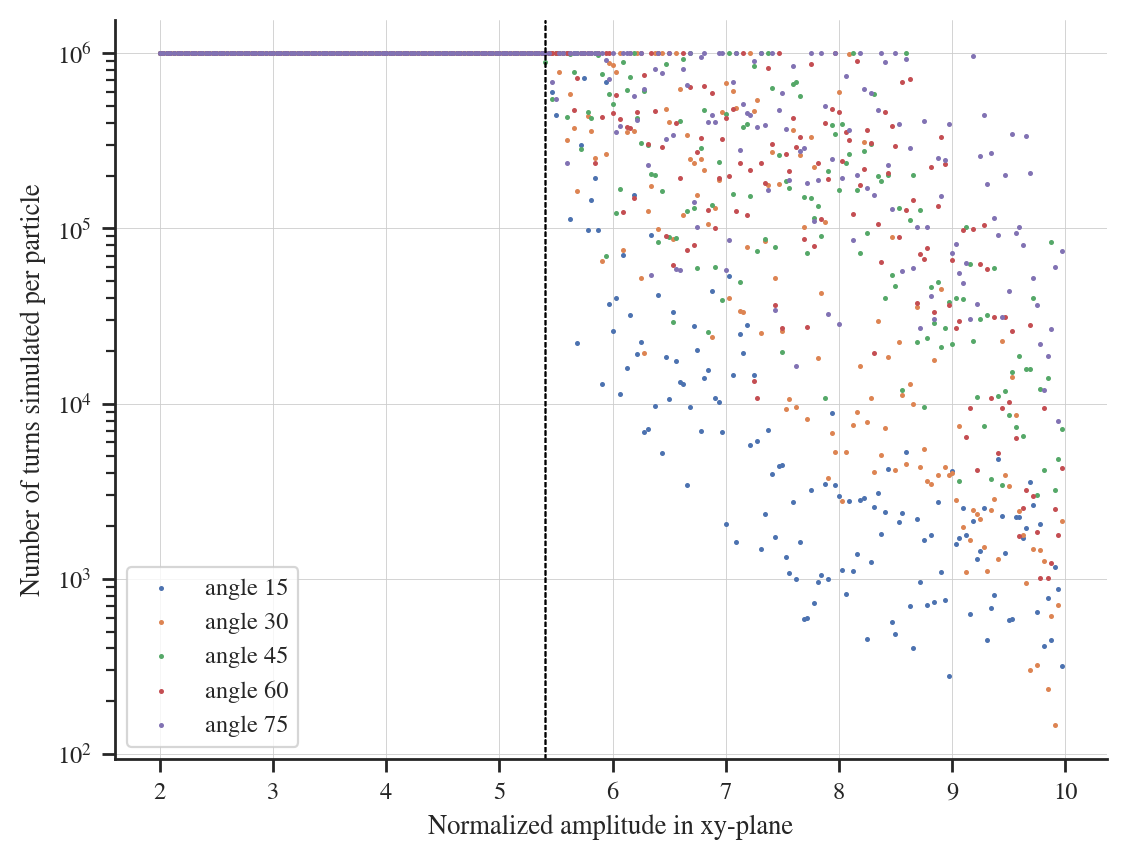

In [15]:
for angle in l_angle:
    df_angle = df_best[df_best["angle in xy-plane [deg]"] == angle]
    plt.scatter(df_angle ['normalized amplitude in xy-plane'], df_angle ['at_turn'], s = 1, label = f"angle {angle}")
    plt.axvline(R_min, color="black", linestyle="--")
    plt.yscale("log")
    plt.legend()
    plt.grid()
    plt.xlabel("Normalized amplitude in xy-plane")
    plt.ylabel("Number of turns simulated per particle")
    #plt.title(f"Number of turns simulated per particle for WP {WP} and angle {angle}")
    #plt.show()
plt.show()

Assume we only simulate particles with amplitude between 4.5 and 6.5

In [16]:
def plot_survival(df, interval = [4.5, 6.5]):
    df_angle = df.copy()
    plt.scatter(df_angle['normalized amplitude in xy-plane'], df_angle['at_turn'], s = 1)
    plt.axvline(R_min, color="black", linestyle="--")
    # Add transparent rectangle between x = 4.5 and w = 6.5
    plt.axvspan(4.5, 6.5, alpha=0.2, color='grey')
    plt.yscale("log")
    plt.legend()
    plt.grid()
    plt.xlabel("Normalized amplitude in xy-plane")
    plt.ylabel("Number of turns simulated per particle")
    plt.title(f"Number of turns simulated per particle for WP {WP} and angle {angle}")
    plt.show()
    
    half_interval = [interval[0], interval[0] + (interval[1] - interval[0])/2]
    df_half_interval  = df_angle[(df_angle['normalized amplitude in xy-plane'] >= half_interval[0]) & (df_angle['normalized amplitude in xy-plane'] <= half_interval[1])]
    print(f'Percentage of particles surviving in the interval {half_interval}:', len(df_half_interval[df_half_interval['at_turn']==10**6])/len(df_half_interval)*100)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


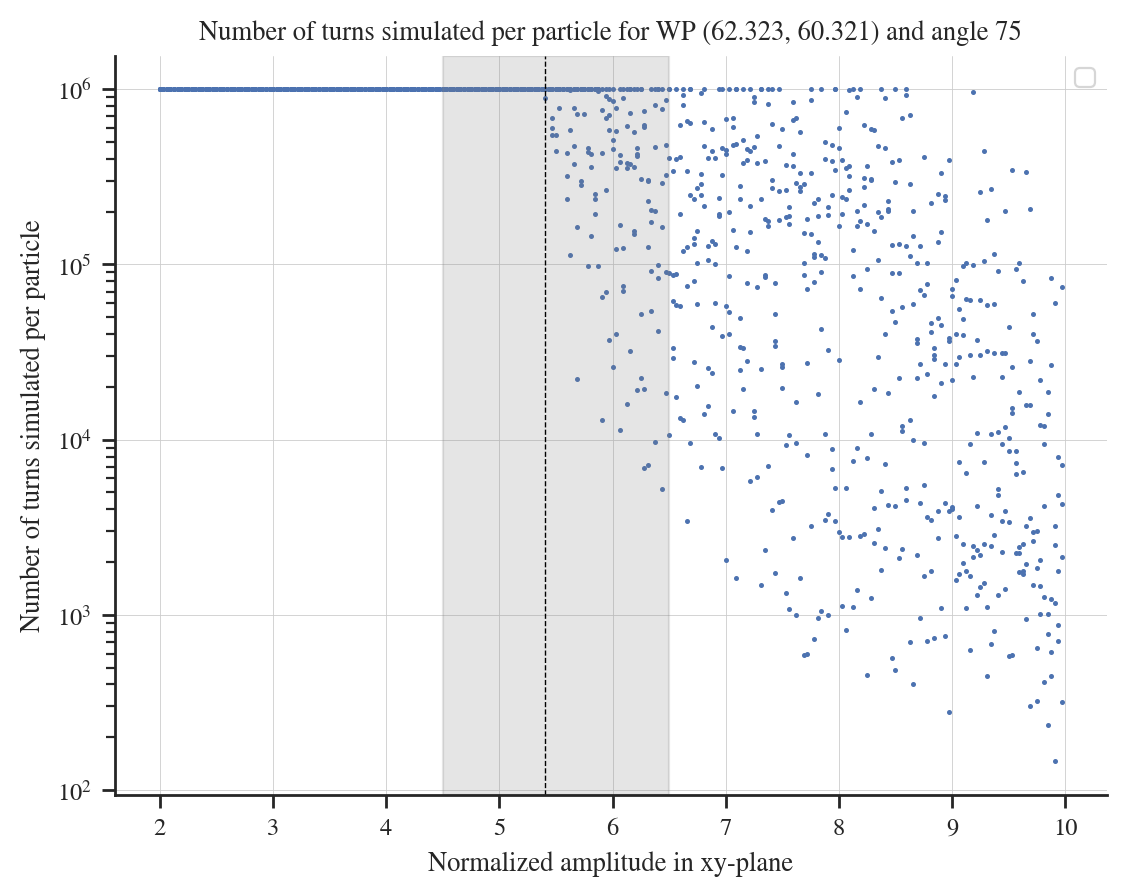

Percentage of particles surviving in the interval [4.5, 5.5]: 96.36363636363636


In [17]:
plot_survival(df_best, interval = [4.5, 6.5])


It doesn't seem risky to assume that if the first 0.5 points of DA are not lost, then the DA corresponds to the first particle lost in the interval. Another rule, or an additional rule, could be to consider the percentage of particles surviving in the first half of the interval: if it's higher than e.g. 90%, the DA is already found. 

Let's run some safety checks on other intervals, considering the angle for simplification 45.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


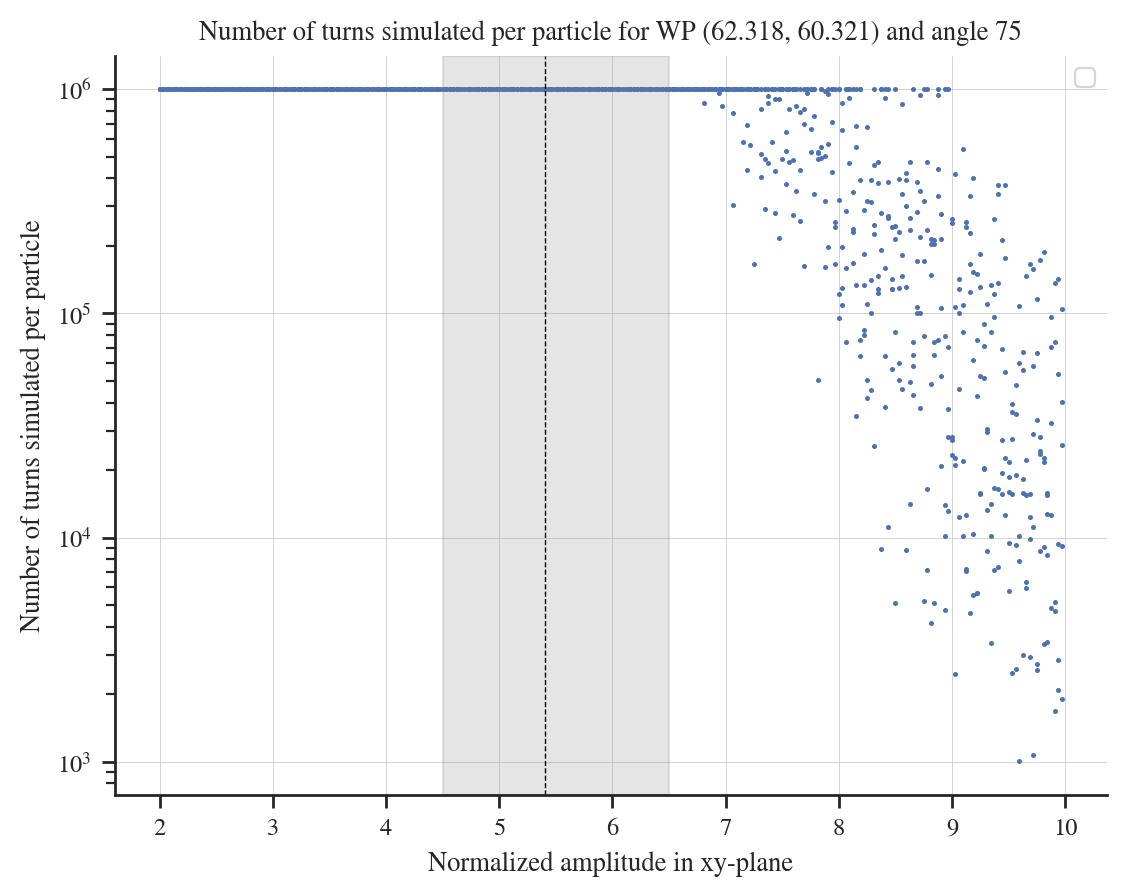

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Percentage of particles surviving in the interval [4.5, 5.5]: 100.0


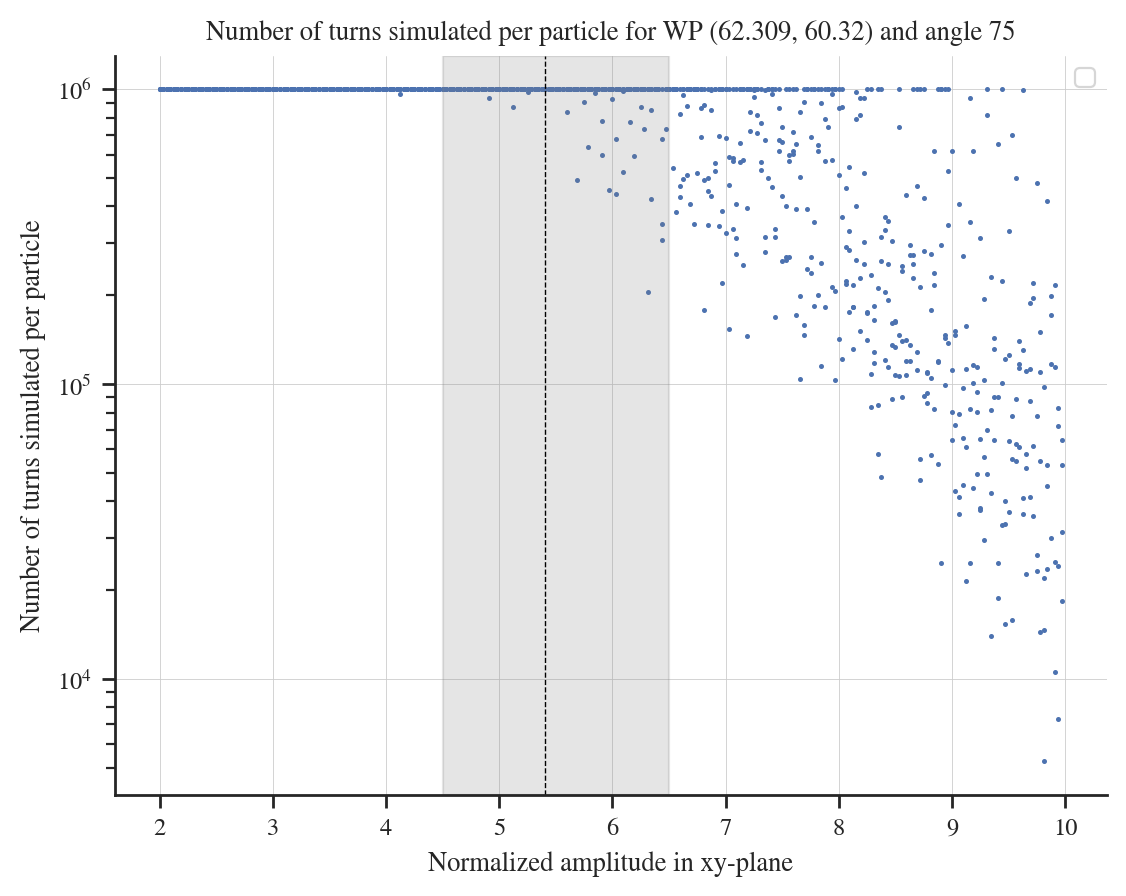

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Percentage of particles surviving in the interval [4.5, 5.5]: 97.41379310344827


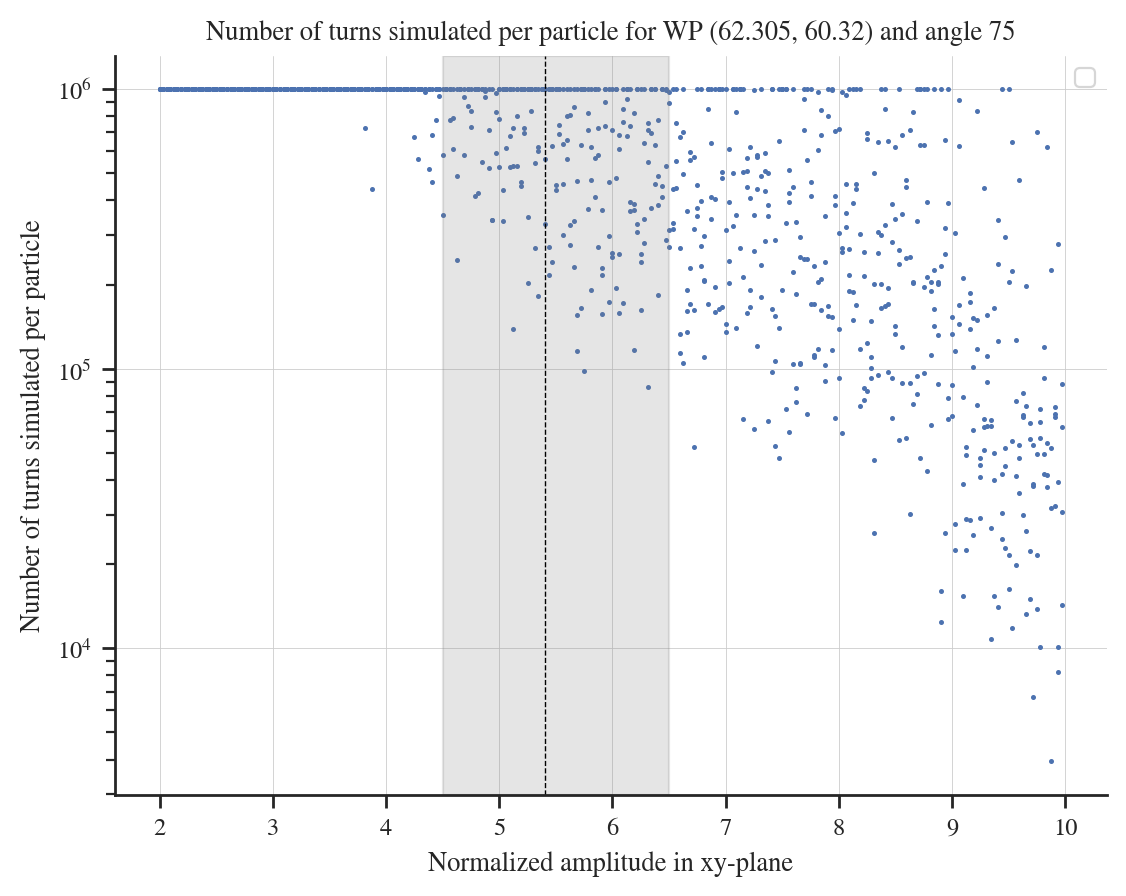

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Percentage of particles surviving in the interval [4.5, 5.5]: 51.724137931034484


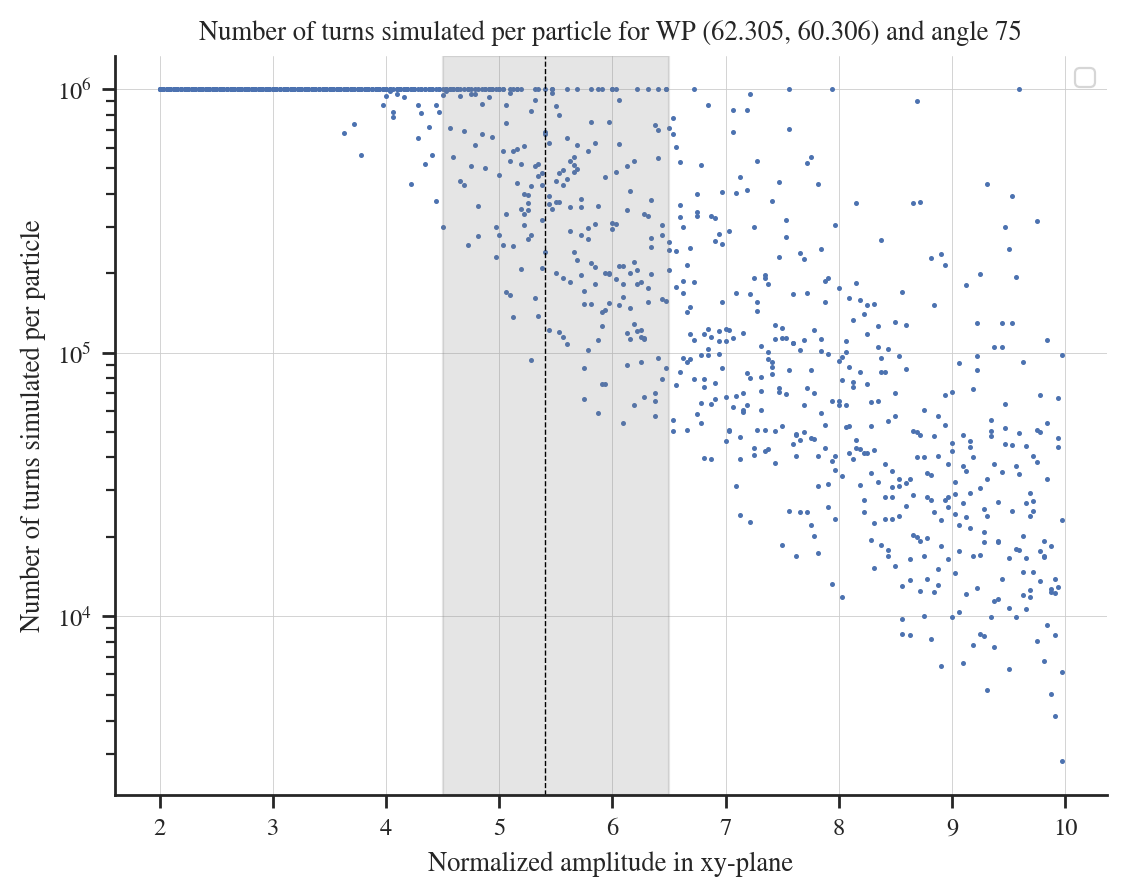

Percentage of particles surviving in the interval [4.5, 5.5]: 33.62068965517241


In [18]:
WP = (62.318, 60.321)
df_best = df_init[(df_init["qx"] == WP[0]) & (df_init["qy"] == WP[1])]
plot_survival(df_best, interval = [4.5, 6.5])

WP = (62.309, 60.320)
df_best = df_init[(df_init["qx"] == WP[0]) & (df_init["qy"] == WP[1])]
plot_survival(df_best, interval = [4.5, 6.5])


WP = (62.305, 60.320)
df_best = df_init[(df_init["qx"] == WP[0]) & (df_init["qy"] == WP[1])]
plot_survival(df_best, interval = [4.5, 6.5])

WP = (62.305, 60.306)
df_best = df_init[(df_init["qx"] == WP[0]) & (df_init["qy"] == WP[1])]
plot_survival(df_best, interval = [4.5, 6.5])

Let's now compute how much time would have been gained with this strategy (scanning al WP, as it's now higly relevant).

In [21]:
l_tot_turns_no_strategy = []
l_tot_turns_strategy = []
for qx in np.linspace(62.305, 62.329, 25, endpoint=True):
    for qy in np.linspace(60.305, 60.329, 25, endpoint=True):
        df_best = df_init[(df_init["qx"] == qx) & (df_init["qy"] == qy)]

        if len(df_best) == 0:
            continue
        
        # Remove entries with nan
        df_best = df_best.dropna()

        # Get total number of turns simulated with no strategy
        n_turns_simulated = df_best["at_turn"].sum()
        l_tot_turns_no_strategy.append(n_turns_simulated)

        # Get total number of turns simulated with strategy
        df_curr = df_best.copy()
        df_curr = df_curr[
            (df_curr["normalized amplitude in xy-plane"] >= 4.5)
            & (df_curr["normalized amplitude in xy-plane"] < 6.5)
        ]

        n_turns_simulated_curr = df_curr["at_turn"].sum()

        # All particles survived, need to simulate higher DA
        if len(df_curr[df_curr["state"] == -1]) == len(df_curr):
            df_curr = df_curr[df_curr["normalized amplitude in xy-plane"] >= 6.5]
            n_turns_simulated_curr += df_curr["at_turn"].sum()

        # Zero particles survived, need to simulate lower DA
        elif len(df_curr[df_curr["state"] == -1]) == 0:
            df_curr = df_curr[df_curr["normalized amplitude in xy-plane"] < 4.5]
            n_turns_simulated_curr += df_curr["at_turn"].sum()

        # Else, some particles survived, need to apply finer strategy
        else:
            # Check surval in half interval
            df_curr = df_curr[
                (df_curr["normalized amplitude in xy-plane"] >= 4.5)
                & (df_curr["normalized amplitude in xy-plane"] < 5.5)
            ]
            if len(df_curr[df_curr["at_turn"] == 10**6]) / len(df_curr) * 100 > 90:
                # All good, turns have already been accounted for, but let's just check that the DA is correct
                curr_DA = df_curr[df_curr["state"] == -1]["normalized amplitude in xy-plane"].min()
                true_DA = df_best[df_best["state"] == -1]["normalized amplitude in xy-plane"].min()
                if curr_DA != true_DA:
                    print(f"Warning, DA is not correct. Found {curr_DA} instead of {true_DA}")
            else:
                # Need to simulate lower DA
                df_curr = df_curr[df_curr["normalized amplitude in xy-plane"] < 4.5]
                n_turns_simulated_curr += df_curr["at_turn"].sum()

        l_tot_turns_strategy.append(n_turns_simulated_curr)

Warning, DA is not correct. Found 4.625 instead of 4.125
Warning, DA is not correct. Found 4.5 instead of 3.906
Warning, DA is not correct. Found 4.688 instead of 4.375
Warning, DA is not correct. Found 4.625 instead of 4.312
Warning, DA is not correct. Found 5.062 instead of 4.0
Warning, DA is not correct. Found 4.656 instead of 4.0
Warning, DA is not correct. Found 4.906 instead of 4.125
Warning, DA is not correct. Found 4.594 instead of 4.094
Warning, DA is not correct. Found 4.781 instead of 4.281
Warning, DA is not correct. Found nan instead of 5.531
Warning, DA is not correct. Found nan instead of 5.781
Warning, DA is not correct. Found nan instead of 5.5
Warning, DA is not correct. Found nan instead of 5.531
Warning, DA is not correct. Found nan instead of 5.906
Warning, DA is not correct. Found nan instead of 5.594
Warning, DA is not correct. Found nan instead of 5.562
Warning, DA is not correct. Found nan instead of 5.594
Warning, DA is not correct. Found nan instead of 5.719
